In [116]:
# Import Analysis Packages

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None


### EDA

In [117]:
# Read Data

data = pd.read_csv('train.csv')

data.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [118]:
print(data.shape)
print(data.isnull().sum())

(5407, 10)
id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64


In [119]:
data.columns

Index(['id', 'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')

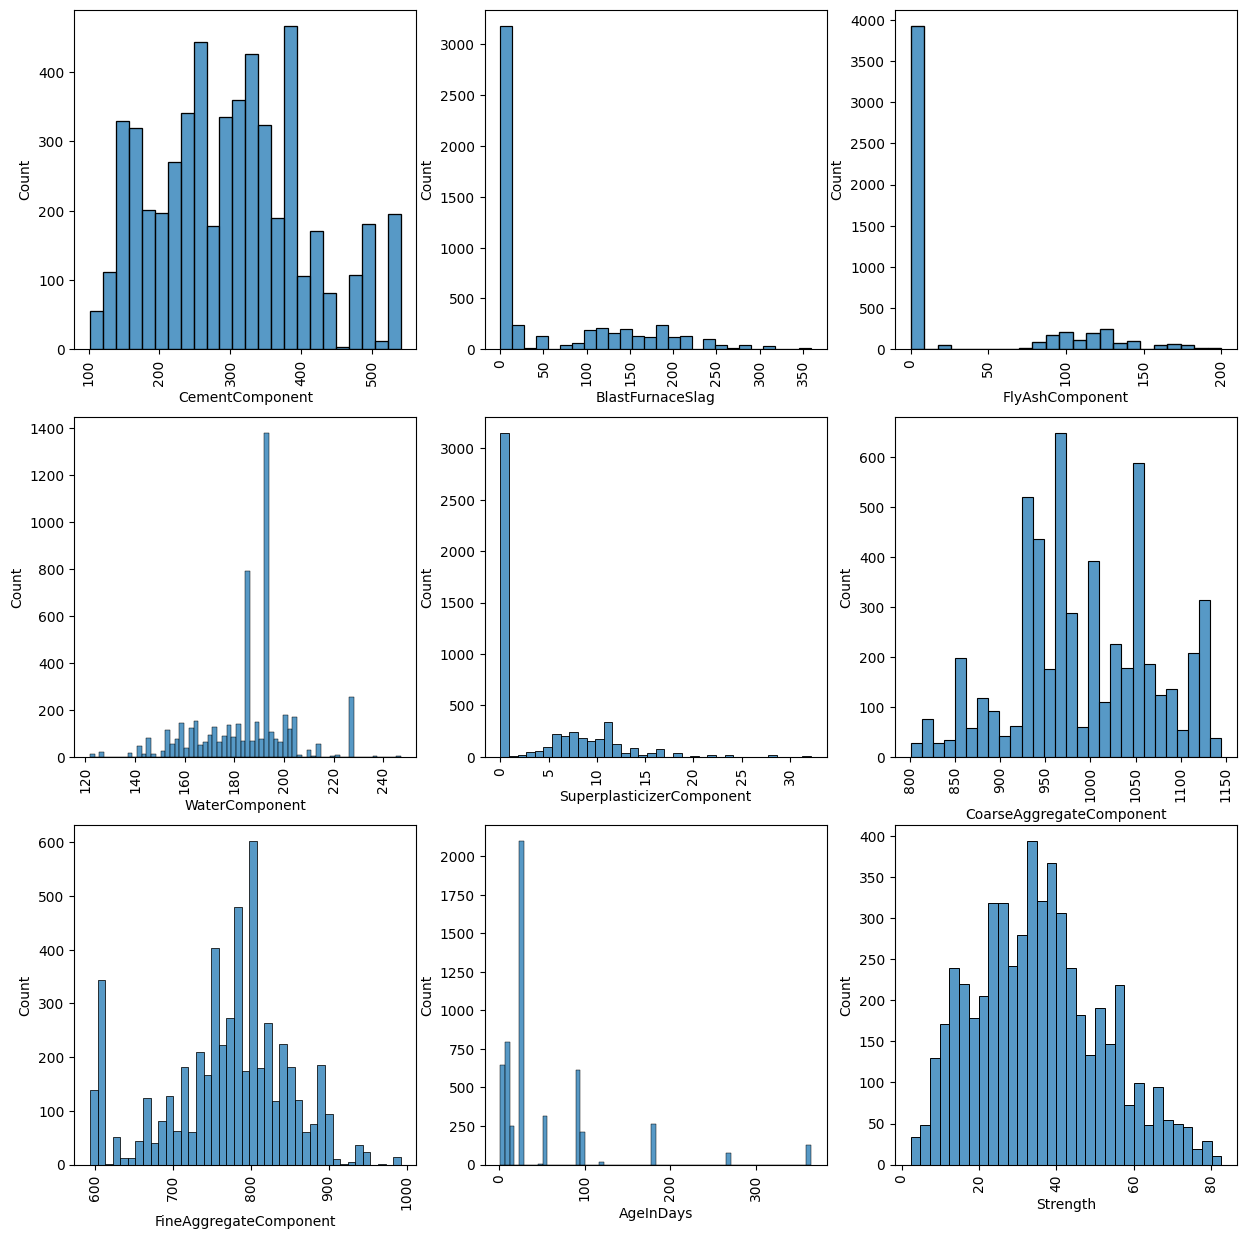

In [120]:
# Distribution of the Variables

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for variable, subplot in zip(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'], ax.flatten()):
    sns.histplot(data[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

<AxesSubplot: >

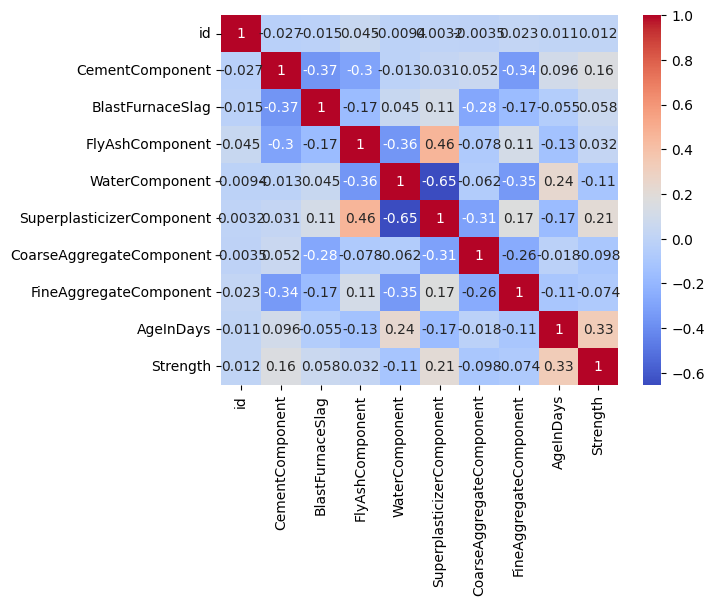

In [121]:
# Correlation Matrix

sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

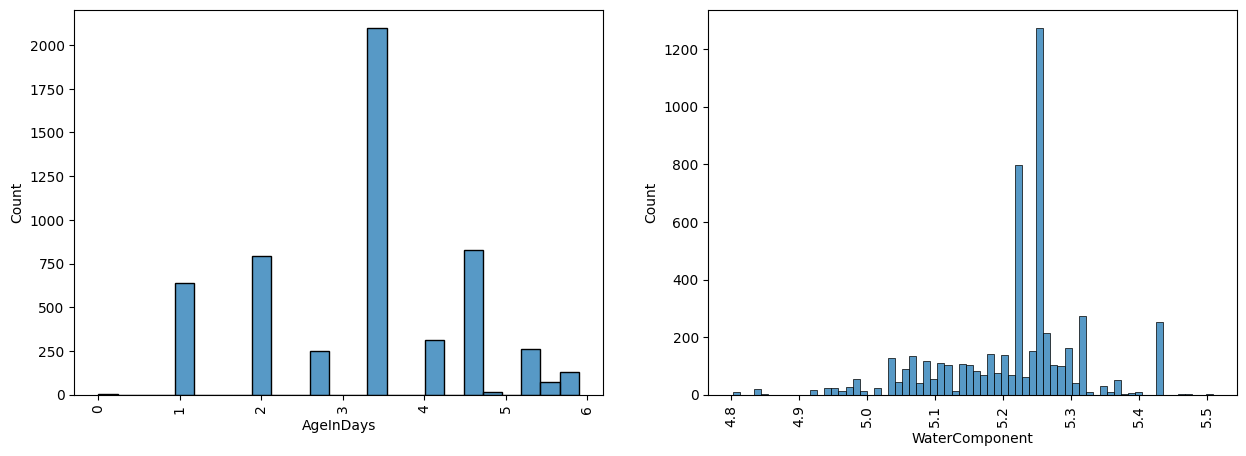

In [122]:
# Log Normalize the Age and Water Component

data['AgeInDays'] = np.log(data['AgeInDays'])
data['WaterComponent'] = np.log(data['WaterComponent'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for variable, subplot in zip(['AgeInDays', 'WaterComponent'], ax.flatten()):
    sns.histplot(data[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [123]:
data['BlastFurnaceSlag']

0         0.0
1       169.0
2       134.7
3        76.0
4       236.0
        ...  
5402     24.0
5403      0.0
5404      0.0
5405     93.4
5406      0.0
Name: BlastFurnaceSlag, Length: 5407, dtype: float64

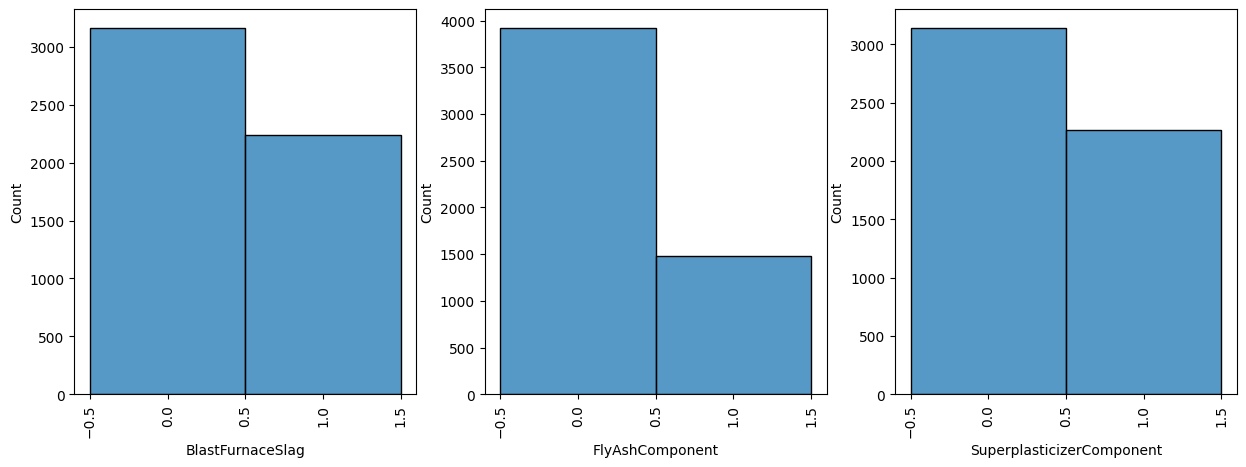

In [124]:
# Binary Encode Slag, Ash, and Superplasticizer

data['BlastFurnaceSlag'] = data['BlastFurnaceSlag'].apply(lambda x: 1 if x > 0 else 0)
data['FlyAshComponent'] = data['FlyAshComponent'].apply(lambda x: 1 if x > 0 else 0)
data['SuperplasticizerComponent'] = data['SuperplasticizerComponent'].apply(lambda x: 1 if x > 0 else 0)

# Convert to Categorical
data['BlastFurnaceSlag'] = data['BlastFurnaceSlag'].astype('category')
data['FlyAshComponent'] = data['FlyAshComponent'].astype('category')
data['SuperplasticizerComponent'] = data['SuperplasticizerComponent'].astype('category')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for variable, subplot in zip(['BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent'], ax.flatten()):
    sns.histplot(data[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

### Model Imports / Data Splits

In [125]:
# Import Linear Regression Packages

from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Import Decision Tree Packages

from sklearn.tree import DecisionTreeRegressor

# Import Random Forest Packages

from sklearn.ensemble import RandomForestRegressor

# Import XgBoost, LightGBM, and CatBoost Packages

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Import Train Test Split and k-Fold Cross Validation

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

# Import Metrics

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [126]:
# Create X and y
x = data.drop('Strength', axis=1).drop('id', axis=1)
y = data['Strength']

# Create K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(x)

# Create Train Test Split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [127]:
x.head()
print(x.shape)

(5407, 8)


In [128]:
y.head()
print(y.shape)

(5407,)


### Linear Models

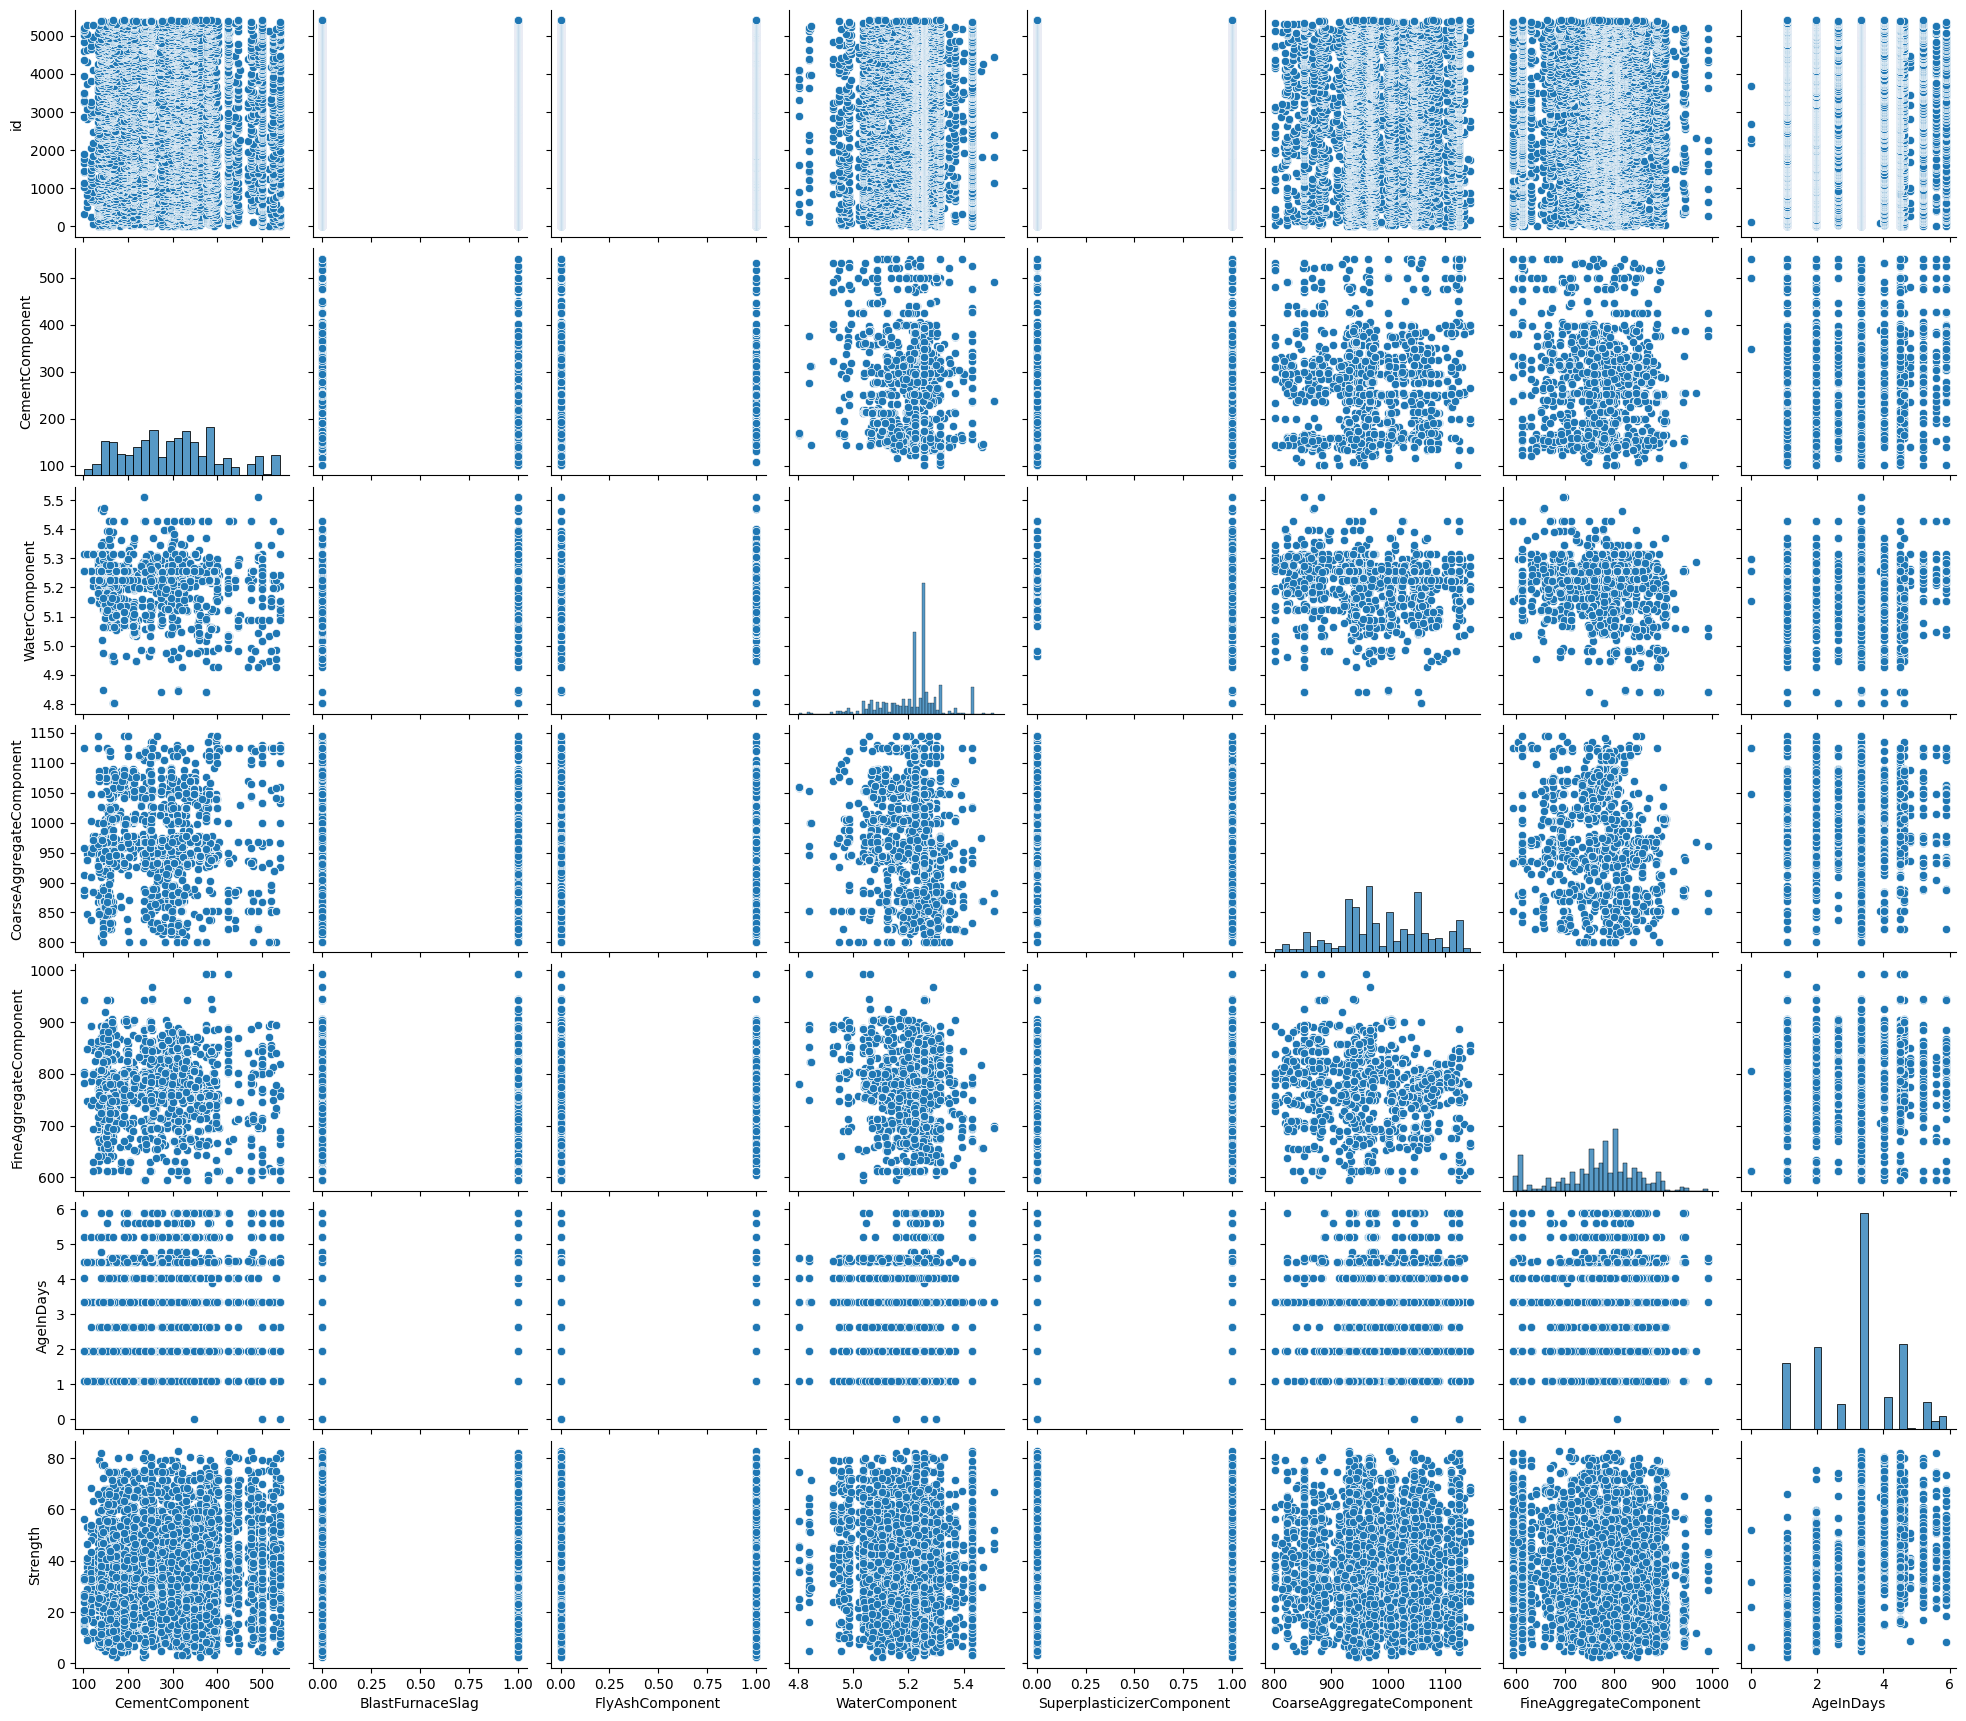

In [129]:
# Pairplots to Assess Linearity and Normality

sns.pairplot(data, x_vars=['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays'])

In [130]:
# Linear Regression

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')

R2 Score:  0.4509004644601592
MSE:  149.42037714530863
MAE:  9.530918126739431
RMSE:  12.223762806325581

R2 Score:  0.3865272204333874
MSE:  159.93024745247183
MAE:  9.651614308832926
RMSE:  12.646353128569194

R2 Score:  0.400009339076979
MSE:  161.80050744802898
MAE:  9.728641616348217
RMSE:  12.720082839668498

R2 Score:  0.41755633453646634
MSE:  158.16369917657377
MAE:  9.58522608778562
RMSE:  12.576315007846048

R2 Score:  0.4083916586598727
MSE:  159.51937445968372
MAE:  9.694516191549523
RMSE:  12.630097959227541



In [131]:
# Lasso Regression

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = Lasso()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')
    
print(y_pred)

R2 Score:  0.4047271658037407
MSE:  161.9850056921205
MAE:  10.029100102641273
RMSE:  12.727333015684021

R2 Score:  0.3521444130484819
MSE:  168.89372729433748
MAE:  10.191159286651994
RMSE:  12.995911945467217

R2 Score:  0.3608788426283701
MSE:  172.3528953340973
MAE:  10.238514823019695
RMSE:  13.128324163201382

R2 Score:  0.3803028858036258
MSE:  168.27994493225847
MAE:  10.054110535135614
RMSE:  12.972276012028825

R2 Score:  0.3647164214872919
MSE:  171.2958252402229
MAE:  10.120292197876969
RMSE:  13.088003103614504

[53.219757   40.09443405 25.60883041 ... 39.77254951 22.53637558
 33.53234129]


In [132]:
# Ridge Regression

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = Ridge()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    print(y_pred)
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')

[45.83864997 30.46248438 48.71486149 ... 19.84692685 35.27156801
 29.79704934]
R2 Score:  0.4507967805840575
MSE:  149.44859149055623
MAE:  9.532017234545636
RMSE:  12.224916829596683

[16.63431574 49.03192871 29.26080743 ... 30.75243932 46.48451831
 41.25353674]
R2 Score:  0.38644805507581614
MSE:  159.9508855893994
MAE:  9.653154417310498
RMSE:  12.647169074120873

[21.45958675 31.56822602 33.73174604 ... 32.430504   31.40991447
 51.24213249]
R2 Score:  0.3999767526756183
MSE:  161.80929507860301
MAE:  9.729759194583385
RMSE:  12.720428258459028

[36.09665879 35.69850497 54.32721295 ... 22.47913593 32.92221457
 46.81148529]
R2 Score:  0.4177207063726901
MSE:  158.11906368785762
MAE:  9.584708895111312
RMSE:  12.574540297277576

[52.67836818 40.71483189 21.48827078 ... 39.12698426 20.43260219
 32.16432879]
R2 Score:  0.4084246838878539
MSE:  159.51046964320156
MAE:  9.69456771790814
RMSE:  12.629745430657007



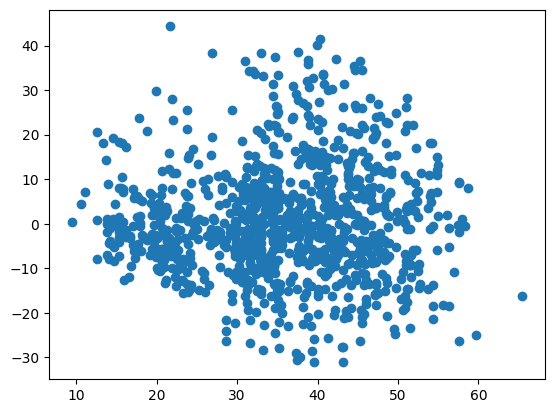

In [133]:
# Assess Homo/Heteroscedasticity

plt.scatter(y_pred, y_test - y_pred)

### Nonlinear Models

In [134]:
# Random Forest Regression

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model =  RandomForestRegressor()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')

R2 Score:  0.4119767878329108
MSE:  160.01224631490751
MAE:  9.976572197329741
RMSE:  12.649594709511744

R2 Score:  0.3420778541842582
MSE:  171.51804462963557
MAE:  9.987612677234893
RMSE:  13.096489782748488

R2 Score:  0.3739167812022869
MSE:  168.83693214545255
MAE:  9.877096289742347
RMSE:  12.993726645787673

R2 Score:  0.38585566307679686
MSE:  166.77207756876092
MAE:  9.827741937288241
RMSE:  12.914026388727914

R2 Score:  0.34505223605691904
MSE:  176.59801308971583
MAE:  10.180533057875
RMSE:  13.289018514913577



In [135]:
# CatBoost Regression

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Convert categorical variables to int
    
    x_train.loc[:,'BlastFurnaceSlag'].astype(int, copy =False)
    x_train.loc[:,'FlyAshComponent'].astype(int, copy=False)
    x_train.loc[:,'SuperplasticizerComponent'].astype(int, copy=False)
    
    model = cb.CatBoostRegressor()  
    model.fit(x_train, y_train,
              cat_features=['BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent'])
    
    y_pred = model.predict(x_test)
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')

Learning rate set to 0.051602
0:	learn: 16.0364462	total: 8.69ms	remaining: 8.68s
1:	learn: 15.7355450	total: 10.4ms	remaining: 5.21s
2:	learn: 15.4474883	total: 12.2ms	remaining: 4.05s
3:	learn: 15.1915814	total: 14ms	remaining: 3.48s
4:	learn: 14.9534375	total: 15.7ms	remaining: 3.13s
5:	learn: 14.7214737	total: 17.4ms	remaining: 2.88s
6:	learn: 14.5040965	total: 19ms	remaining: 2.7s
7:	learn: 14.3093469	total: 20.8ms	remaining: 2.58s
8:	learn: 14.1252690	total: 22.5ms	remaining: 2.48s
9:	learn: 13.9683757	total: 24.2ms	remaining: 2.4s
10:	learn: 13.8023307	total: 25.8ms	remaining: 2.32s
11:	learn: 13.6651994	total: 27.7ms	remaining: 2.28s
12:	learn: 13.5395460	total: 29.5ms	remaining: 2.24s
13:	learn: 13.4266995	total: 31.2ms	remaining: 2.2s
14:	learn: 13.3220908	total: 32.9ms	remaining: 2.16s
15:	learn: 13.2335475	total: 34.7ms	remaining: 2.14s
16:	learn: 13.1489958	total: 36.7ms	remaining: 2.12s
17:	learn: 13.0582326	total: 38.4ms	remaining: 2.09s
18:	learn: 12.9729688	total: 40ms

In [136]:
# XGBoost Regression

for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    x_train['BlastFurnaceSlag'] = x_train['BlastFurnaceSlag'].astype(int)
    x_train['FlyAshComponent'] = x_train['FlyAshComponent'].astype(int)
    x_train['SuperplasticizerComponent'] = x_train['SuperplasticizerComponent'].astype(int)
    
    model = xgb.XGBRegressor(
        tree_method='gpu_hist',
        enable_categorical=True,
    )  
    
    print(x_train.dtypes)
    
    model.fit(x_train, y_train)
    
    x_test['BlastFurnaceSlag'] = x_test['BlastFurnaceSlag'].astype(int)
    x_test['FlyAshComponent'] =  x_test['FlyAshComponent'].astype(int)
    x_test['SuperplasticizerComponent'] = x_test['SuperplasticizerComponent'].astype(int)
    
    y_pred = model.predict(x_test)
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')

CementComponent              float64
BlastFurnaceSlag               int32
FlyAshComponent                int32
WaterComponent               float64
SuperplasticizerComponent      int32
CoarseAggregateComponent     float64
FineAggregateComponent       float64
AgeInDays                    float64
dtype: object
R2 Score:  0.40418673690594253
MSE:  162.13206662461582
MAE:  9.942514491759916
RMSE:  12.733109071417546

CementComponent              float64
BlastFurnaceSlag               int32
FlyAshComponent                int32
WaterComponent               float64
SuperplasticizerComponent      int32
CoarseAggregateComponent     float64
FineAggregateComponent       float64
AgeInDays                    float64
dtype: object
R2 Score:  0.361039525819716
MSE:  166.57480193366197
MAE:  9.756508495344912
RMSE:  12.906386091143483

CementComponent              float64
BlastFurnaceSlag               int32
FlyAshComponent                int32
WaterComponent               float64
SuperplasticizerComp

### Submission

In [137]:
# Load Test Data and Preprocess

X_test = pd.read_csv('test.csv').drop('id', axis=1)

X_test['AgeInDays'] = np.log(X_test['AgeInDays'])
X_test['WaterComponent'] = np.log(X_test['WaterComponent'])
X_test['BlastFurnaceSlag'] = X_test['BlastFurnaceSlag'].apply(lambda x: 1 if x > 0 else 0).astype(int)
X_test['FlyAshComponent'] = X_test['FlyAshComponent'].apply(lambda x: 1 if x > 0 else 0).astype(int)
X_test['SuperplasticizerComponent'] = X_test['SuperplasticizerComponent'].apply(lambda x: 1 if x > 0 else 0).astype(int)

In [142]:
x['BlastFurnaceSlag'] = x['BlastFurnaceSlag'].astype(int)
x['FlyAshComponent'] = x['FlyAshComponent'].astype(int)
x['SuperplasticizerComponent'] = x['SuperplasticizerComponent'].astype(int)

In [143]:
# Model Ensemble 
models = [LinearRegression(), Lasso(), Ridge()]
preds = []

for model in models:
    model.fit(x, y)
    preds.append(model.predict(X_test))
    
mean = np.mean(preds, axis=0)
sample = pd.read_csv('sample_submission.csv')
sample['Strength'] = mean
sample.to_csv('submission.csv', index=False)
    
    

    

In [145]:
# Non-Linear Model Ensemble 
models = [cb.CatBoostRegressor(), xgb.XGBRegressor(), RandomForestRegressor()]    
preds = []

for model in models:
    model.fit(x, y)
    preds.append(model.predict(X_test))
    
mean = np.mean(preds, axis=0)
sample = pd.read_csv('sample_submission.csv')
sample['Strength'] = mean
sample.to_csv('submission.csv', index=False)

Learning rate set to 0.053455
0:	learn: 16.0436760	total: 3.88ms	remaining: 3.88s
1:	learn: 15.7413624	total: 7.43ms	remaining: 3.71s
2:	learn: 15.4374743	total: 10.8ms	remaining: 3.59s
3:	learn: 15.1680925	total: 15ms	remaining: 3.73s
4:	learn: 14.9020054	total: 19.3ms	remaining: 3.84s
5:	learn: 14.6601450	total: 23.4ms	remaining: 3.88s
6:	learn: 14.4400432	total: 27.4ms	remaining: 3.89s
7:	learn: 14.2615152	total: 31.2ms	remaining: 3.86s
8:	learn: 14.0848239	total: 34.6ms	remaining: 3.81s
9:	learn: 13.9052927	total: 38ms	remaining: 3.77s
10:	learn: 13.7488619	total: 41.7ms	remaining: 3.75s
11:	learn: 13.6017953	total: 47ms	remaining: 3.87s
12:	learn: 13.4714756	total: 50.5ms	remaining: 3.84s
13:	learn: 13.3504015	total: 54.3ms	remaining: 3.82s
14:	learn: 13.2367932	total: 58.2ms	remaining: 3.82s
15:	learn: 13.1370712	total: 62ms	remaining: 3.81s
16:	learn: 13.0419494	total: 66.1ms	remaining: 3.82s
17:	learn: 12.9481031	total: 69.9ms	remaining: 3.81s
18:	learn: 12.8761144	total: 73.8m

In [147]:
# Entire Ensemble

models = [LinearRegression(), Lasso(), Ridge(), cb.CatBoostRegressor(), xgb.XGBRegressor(), RandomForestRegressor()]
preds = []

for model in models:
    model.fit(x, y)
    preds.append(model.predict(X_test))
    
mean = np.mean(preds, axis=0)
sample = pd.read_csv('sample_submission.csv')
sample['Strength'] = mean
sample.to_csv('submission.csv', index=False)

Learning rate set to 0.053455
0:	learn: 16.0436760	total: 3.71ms	remaining: 3.71s
1:	learn: 15.7413624	total: 8.28ms	remaining: 4.13s
2:	learn: 15.4374743	total: 11.9ms	remaining: 3.96s
3:	learn: 15.1680925	total: 15.7ms	remaining: 3.91s
4:	learn: 14.9020054	total: 19.7ms	remaining: 3.91s
5:	learn: 14.6601450	total: 22.8ms	remaining: 3.78s
6:	learn: 14.4400432	total: 26.2ms	remaining: 3.72s
7:	learn: 14.2615152	total: 30ms	remaining: 3.72s
8:	learn: 14.0848239	total: 33.7ms	remaining: 3.71s
9:	learn: 13.9052927	total: 37.8ms	remaining: 3.74s
10:	learn: 13.7488619	total: 42.4ms	remaining: 3.82s
11:	learn: 13.6017953	total: 46.3ms	remaining: 3.81s
12:	learn: 13.4714756	total: 50.4ms	remaining: 3.83s
13:	learn: 13.3504015	total: 54ms	remaining: 3.81s
14:	learn: 13.2367932	total: 58ms	remaining: 3.81s
15:	learn: 13.1370712	total: 61.8ms	remaining: 3.8s
16:	learn: 13.0419494	total: 65.9ms	remaining: 3.81s
17:	learn: 12.9481031	total: 69.6ms	remaining: 3.79s
18:	learn: 12.8761144	total: 74.1

### Skip Preprocessing

In [111]:
x = pd.read_csv('train.csv').drop('id', axis=1).drop('Strength', axis=1)
y = data['Strength']

In [112]:
x_test = pd.read_csv('test.csv').drop('id', axis=1)

x_test['BlastFurnaceSlag'] = x_test['BlastFurnaceSlag'].astype(int)
x_test['FlyAshComponent'] = x_test['FlyAshComponent'].astype(int)
x_test['SuperplasticizerComponent'] = x_test['SuperplasticizerComponent'].astype(int)

In [46]:
# Model Ensemble 
models = [LinearRegression(), Lasso(), Ridge()]
preds = []

for model in models:
    model.fit(x, y)
    preds.append(model.predict(X_test))
    
mean = np.mean(preds, axis=0)
sample = pd.read_csv('sample_submission.csv')
sample['Strength'] = mean
sample.to_csv('submission.csv', index=False)